# Boundary Relation Tests

## Setup

### Imports

In [1]:
from math import sqrt, pi

# Shared Packages
import pandas as pd
import numpy as np

# Local functions and classes
from types_and_classes import *
from utilities import *
from debug_tools import *
from structure_slice import *
from metrics import *
from relations import *

### Global Settings

In [2]:
PRECISION = 2

In [3]:
%matplotlib inline

## Adjusting Boundary Slice Relations

For the beginning and ending slices of a structure the entire contour must
be treated as a boundary.  The structure does not have an interior on these
slices. In this case the “*Interior*” relations become “*Boundary*” relations.

The “*Interior*” bits of the DE-9IM relationship metric are combined with the 
“*Boundary*” bits using "OR" logic.  This will keep the “*Boundary*” bits as 
part of the boundary.


### Boundary Interpolation

- The last slice with a contour is not the actual boundary.  The boundary is
  half way between the last slice with a contour and the fist slice without a 
  contour.  
- The last slice is interpolated to create the boundary.
- The boundary slice index is half way between the two indexes (The mean).


#### Interpolation process
- Takes two polygons or one polygon an a "vanishing point" (The centroid of the polygon).
- Takes two SliceIndex values and calculates the mean as the new SliceIndex.
- For each coordinate point on the first polygon build a line from it to the 
  closest point on the second polygon.
- Return the half way point of this line as the new coordinate point.
- The new polygon is the set of all the new coordinate points.
_ To interpolate a polygon on a boundary slice, the centroid of the polygon is 
    used as the second point in the interpolation lines.
The Z value of the new point is the mean of the Z values of the two slices.


### Managing holes
The boundaries of holes must also be checked
- `adjust_boundary_relation` will need to be updated to include `shift_type`s for holes:
     - *hole_in_a* 
     - *hole_in_b*
     - *hole_in_both*
- The *holes* `shift_type` shifts the interior relation to a boundary relation only for the *contour* part.  The *exterior* and *hull* relation parts are not shifted.

- The `boundary_match` and `match_neighbour_slices` functions will need to be updated to include the hole boundary tests.
  - For hole boundaries, select the neighboring slice (s) that *DO* have a hole contour.
  - The Secondary slice selection works as usual.
  

When hole boundaries are tested, only the "contour" “*Boundary*” bits of the 'a' 
structure DE-9IM relationship


relation (DE27IM_Type): A triplet numeric DE-9IM relationship metric.
        

shift_type (str, optional): The polygon(s) that are boundaries:
- 'a' indicates that the first (primary) polygon is at a boundary.
- 'b' indicates that the second (secondary) polygon is at a boundary.
- 'both' (The default) indicates that both polygons are at a boundary.
- 'hole_in_a' indicates that the first polygon is at a boundary with a hole.
- 'hole_in_b' indicates that the second polygon is at a boundary with a hole.

###### Inverted Next_slice required for holes

### secondary boundary tests
- Applies to the Secondary ROI in the same way as the Primary ROI.
- The `boundary_match` and `match_neighbour_slices` functions will need to be adjusted to work for secondary boundaries as well.

|Relationship     | Region Test   |  Exterior Test  |  Hull Test  |
|-------------    |---------------|-----------------|-------------|
|Borders          |  `FF*FT****`  |   `T*T*F*FF*`   | `*********` |
|Borders result   |  `000011001`  |   `000011001`   | `000011001` |
|Interior Borders |  `FF*FT****`  |   `T***T****`   | `*********` |
|Result           |  `111001001`  |   `111001001`   | `001011101` |
                
**BORDERS:** The two structures share a common exterior boundary.

**BORDERS_INTERIOR:** The two structures share a common boundary and one is within the other.
    


|Relationship     | Region Test   |  Exterior Test  |  Hull Test  |
|-------------    |---------------|-----------------|-------------|
|Overlaps         |  `T*T***T**`  |   `*********`   | `*********` |
|Overlaps result  |  `110010001`  |   `110010001`   | `110010001` |

                
**OVERLAPS:** The two structures share a common region.
    

![alt text](Images/DE-9IM.png)

![alt text](../reference/RelationshipTreeDiagram.svg)

### Boundary checks are done by *region* not by *structure*

- For all structures the `StructureSlice.contour` MultiPolygon for each slice 
    is separated into individual polygons and holes (Regions).
- Unique labels are applied to each region on the first slice: 'a', 'b' ...
- Overlapping polygons on the next slice are given the same region labels.
- If a polygon in the current region is not matched to a polygon in the next 
    region, it is a tagged as a “*Boundary*” polygon.
- If a polygon in the next region is not matched with a polygon in the current 
    region, it is tagged as a “*Boundary*” polygon and assigned a new unique 
    region label.
- In the case where two regions that converge into one the distinct region 
    labels are kept. This is because a polygon can be in multiple regions.
  


## Boundary Relations Functions

In [4]:
def is_boundary(region):
    if isinstance(region, Region):
        return region.is_boundary
    return False


def is_hole(region):
    if isinstance(region, Region):
        return region.is_hole
    return False


def find_boundary_slices(region_table: pd.DataFrame, group_regions=False):
    has_boundary = region_table.map(is_boundary)
    boundaries = has_boundary.fillna(0).astype(bool)
    if group_regions:
        boundaries = has_boundary.stack('ROI', future_stack=True)
        boundaries = boundaries.apply(any, axis='columns')
        boundaries = boundaries.unstack('ROI')
    return boundaries


def identify_neighbour_slices(region_table: pd.DataFrame):
    def has_neighbour(region_table: pd.DataFrame, offset: int):
        not_empty = region_table.map(empty_structure, invert=True)
        neighbour = not_empty.shift(offset)
        neighbour['neighbour'] = neighbour.index.to_series()
        neighbour['neighbour'] = neighbour['neighbour'].shift(offset)
        neighbour = neighbour.dropna()
        neighbour.set_index('neighbour', append=True, inplace=True)
        return neighbour

    next_slice = has_neighbour(region_table, 1)
    prev_slice = has_neighbour(region_table, -1)
    neighbour_match = pd.concat([next_slice, prev_slice], axis='index')
    neighbour_match.sort_index(inplace=True)
    return neighbour_match


def find_boundary_pairs(neighbour, region_boundaries, region_idx, is_hole):
    # If the region is a hole, select the neighbour slice that has a contour.
    # Otherwise, select the neighbour slice that has no contour.
    if is_hole:
        nbr_match = neighbour.T
    else:
        nbr_match = neighbour.map(lambda x: not x).T
    boundary_neighbour_index = nbr_match.join(region_boundaries[region_idx],
                                              rsuffix='bdr')
    boundary_neighbour_index = boundary_neighbour_index.T.apply(all)
    index_list = list(boundary_neighbour_index[boundary_neighbour_index].index)
    return index_list


def interpolate_region(region_num, regions: pd.DataFrame,
                       slice_pair: Tuple[int, int]):
    # Matched Interpolated Secondary Slice
    region_1 = regions.at[slice_pair[0], region_num]
    region_2 = regions.at[slice_pair[1], region_num]
    if empty_structure(region_1):
        if empty_structure(region_2):
            interpolated_region = np.nan
        else:
            interpolated_region = interpolate_polygon(slice_pair,
                                                      region_2.polygon)
    else:
        if empty_structure(region_2):
            interpolated_region = interpolate_polygon(slice_pair,
                                                      region_1.polygon)
        else:
            interpolated_region = interpolate_polygon(slice_pair,
                                                      region_1.polygon,
                                                      region_2.polygon)
    return interpolated_region


def set_adjustments(region_table: pd.DataFrame, region_boundaries,
                    selected_roi: StructurePairType,
                    region1: RegionIndexType, region2: RegionIndexType,
                    slices: List[float]):
    # The first region is always a boundary.
    adjustments = ['boundary_a']
    # If the region is a hole, then adjust interior and exterior parts
    # of the relation need to be swapped.
    is_hole = region_table[region1].dropna().iat[1].is_hole
    if is_hole:
        adjustments.append('hole_a')
    # If the "Secondary" ROI is the primary ROI, then the relation needs to be
    # transposed.
    is_secondary_roi = selected_roi.index(region1[0]) == 1
    if is_secondary_roi:
        adjustments.append('transpose')
    # Check whether the secondary slices are also at a boundary.
    if any(region_boundaries.loc[list(slices), region2]):
        adjustments.append('boundary_b')
    is_hole2 = region_table[region2].dropna().iat[1].is_hole
    if is_hole2:
        adjustments.append('hole_b')
    return adjustments


def get_boundary_relations(region_table, neighbour_match, region_boundaries, selected_roi):
    boundary_relations = {}
    nbr_grp = neighbour_match[selected_roi].T.groupby(level=['ROI', 'Label'])
    for region_idx, neighbour in nbr_grp:
        is_hole = region_table[region_idx].dropna().iat[1].is_hole
        index_list = find_boundary_pairs(neighbour, region_boundaries, region_idx, is_hole)
        other_roi_num = [r for r in selected_roi if not r == region_idx[0]][0]
        for slice_pair in index_list:
            # Interpolated Boundary Slice
            boundary_region = interpolate_region(region_idx, region_table,
                                                slice_pair)
            # Loop through the regions of the other roi
            for other_region in region_table[other_roi_num].columns:
                other_region_idx = (other_roi_num, other_region)
                # Interpolate the other roi
                other_region = interpolate_region(other_region_idx, region_table,
                                                slice_pair)
                adjustments = set_adjustments(region_table, region_boundaries,
                                              selected_roi, region_idx,
                                              other_region_idx, slice_pair)
                # Get boundary relation as a DE27IM object.
                boundary_relation = DE27IM(boundary_region, other_region,
                                        adjustments=adjustments)
                region_pair = tuple([region_idx, other_region_idx, slice_pair])
                boundary_relations[region_pair] = boundary_relation
    return boundary_relations


def find_relations(slice_table, selected_roi):
    # Split each Structure into distinct regions for boundary tests.
    region_table = make_region_table(slice_table)
    # Identify the boundary slices of each region.
    region_boundaries = find_boundary_slices(region_table)
    # For each slice of each region identify the whether the region is present on
    # the neighbouring slice.
    neighbour_match = identify_neighbour_slices(region_table)

    boundary_relations = get_boundary_relations(region_table, neighbour_match, region_boundaries, selected_roi)
    # Slice range = Min(starting slice) to Max(ending slice)
    selected_slices = select_slices(slice_table, selected_roi)
    # Send all slices with both Primary and Secondary contours for standard
    # relation testing
    mid_relations = list(selected_slices.agg(relate_structures,
                                             structures=selected_roi,
                                             axis='columns'))
    mid_relations.extend(boundary_relations.values())
    relation =  merged_relations(mid_relations)
    return relation


In [5]:
def parallel_cylinders():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    left_cylinder = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=-2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    right_cylinder = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    # Two concentric cylinders different z offsets
    right_middle_cylinder = make_vertical_cylinder(roi_num=2, radius=1, length=0.5,
                                             offset_x=2.5, offset_z=-0.2,
                                             spacing=slice_spacing)
    left_boundary_cylinder1 = make_vertical_cylinder(roi_num=3, radius=1, length=0.2,
                                             offset_x=-2.5, offset_z=-0.4,
                                             spacing=slice_spacing)
    left_boundary_cylinder2 = make_vertical_cylinder(roi_num=3, radius=1, length=0.2,
                                             offset_x=-2.5, offset_z=0.3,
                                             spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, left_cylinder, right_cylinder,
                            right_middle_cylinder,
                            left_boundary_cylinder1,left_boundary_cylinder2])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


In [6]:
slice_table = parallel_cylinders()

selected_roi = [1, 2]
relation = find_relations(slice_table, selected_roi)
print(relation.identify_relation())


Relationship: Partition


In [7]:
selected_roi = [1, 3]
relation = find_relations(slice_table, selected_roi)
print(relation.identify_relation())

Relationship: Borders


In [8]:
def embedded_cylinder():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    primary_cylinder = make_vertical_cylinder(roi_num=9, radius=6, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    center_hole = make_vertical_cylinder(roi_num=9, radius=4, length=0.5,
                                         offset_z=-0.2, spacing=slice_spacing)
    # Two concentric cylinders different z offsets
    confines_cylinder = make_vertical_cylinder(roi_num=10, radius=3, length=0.5,
                                             offset_z=-0.2,
                                             spacing=slice_spacing)
    surrounds_cylinder = make_vertical_cylinder(roi_num=11, radius=2, length=0.3,
                                         offset_z=-0.1, spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, center_hole,
                            confines_cylinder, surrounds_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#print(find_relationship(embedded_cylinder(), [9, 10]))


In [9]:
slice_table = embedded_cylinder()
selected_roi = [9, 10]

relation = find_relations(slice_table, selected_roi)
print(relation.identify_relation())

Relationship: Confines


# Done To Here

## Test structures


#### Concentric cylinders starting on the same slice
  
<img src="Images\Boundaries\PartitionSup3D.png" alt="PartitionSup3D" style="height:50px;">
<img src="Images\Boundaries\PartitionSup2D.png" alt="PartitionSup2D" style="height:30px;">

In [21]:
def concentric_cylinders_same_start():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Concentric cylinders starting on the same slice
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=2, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    sup_partition = make_vertical_cylinder(roi_num=2, radius=1, length=0.4,
                                           offset_z=-0.3,
                                           spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, sup_partition])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


In [22]:
def parallel_cylinders():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    left_cylinder = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=-2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    right_cylinder = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    # Two concentric cylinders different z offsets
    right_middle_cylinder = make_vertical_cylinder(roi_num=2, radius=1, length=0.5,
                                             offset_x=2.5, offset_z=-0.2,
                                             spacing=slice_spacing)
    left_boundary_cylinder1 = make_vertical_cylinder(roi_num=3, radius=1, length=0.2,
                                             offset_x=-2.5, offset_z=-0.4,
                                             spacing=slice_spacing)
    left_boundary_cylinder2 = make_vertical_cylinder(roi_num=3, radius=1, length=0.2,
                                             offset_x=-2.5, offset_z=0.2,
                                             spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, left_cylinder, right_cylinder,
                            right_middle_cylinder,
                            left_boundary_cylinder1,left_boundary_cylinder2])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#print(find_relationship(dual_embedded_cylinder(), [1, 2]))


In [23]:
def dual_embedded_cylinder():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1.1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Centred cylinder with two embedded cylinders
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    left_hole = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=-2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    right_hole = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    # cylinder with interior borders
    confines_cylinder = make_vertical_cylinder(roi_num=2, radius=1, length=0.5,
                                             offset_x=2.5, offset_z=-0.2,
                                             spacing=slice_spacing)

    # cylinder completely inside of a hole
    surrounds_cylinder = make_vertical_cylinder(roi_num=3, radius=1, length=0.3,
                                             offset_x=-2.5, offset_z=-0.1,
                                             spacing=slice_spacing)
    # cylinder bordering primary cylinder
    bordering_cylinder1 = make_vertical_cylinder(roi_num=4, radius=3, length=0.2,
                                             offset_x=0, offset_z=-0.5,
                                             spacing=slice_spacing)
    # cylinder bordering primary cylinder
    bordering_cylinder2 = make_vertical_cylinder(roi_num=4, radius=3, length=0.2,
                                             offset_x=0, offset_z=0.4,
                                             spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, left_hole, right_hole,
                            confines_cylinder, surrounds_cylinder,
                            bordering_cylinder1, bordering_cylinder2])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#### Embedded boxes

![ContainsCubes](ContainsCubes.png)

In [24]:
def embedded_boxes():
    slice_spacing = 0.5
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=20, length=30, offset_z=-15,
                                spacing=slice_spacing)
    # embedded boxes
    cube6 = make_box(roi_num=1, width=6, spacing=slice_spacing)
    cube3 = make_box(roi_num=2, width=3, offset_z=0, spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([cube6, cube3, body])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table

#### Bordering Cylinders
- Identify the boundary slices of the Primary and the neighbouring slice(s) that do not have a primary.
- For each of these neighbouring slices, if the slice has a Secondary contour, select that Secondary slice.

![Bordering cylinders](FreeCAD_Scripts/BorderingCylinders.png)

In [25]:
def bordering_cylinders():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1.1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Centred cylinder with two embedded cylinders
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    # cylinder bordering primary cylinder
    bordering_cylinder1 = make_vertical_cylinder(roi_num=4, radius=3, length=0.2,
                                             offset_x=0, offset_z=-0.5,
                                             spacing=slice_spacing)
    # cylinder bordering primary cylinder
    bordering_cylinder2 = make_vertical_cylinder(roi_num=4, radius=3, length=0.2,
                                             offset_x=0, offset_z=0.4,
                                             spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, bordering_cylinder1,
                            bordering_cylinder2])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#### Partition Cylinders
- Identify the boundary slices of the Primary and the neighbouring slice(s) that do not have a primary.
- For each of these neighbouring slices, if the slice does not have a Secondary contour, but there is a Secondary contour on the same slice as the Primary boundary, select that Secondary slice.


In [26]:
def partitions_cylinder():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1.1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Centred cylinder with two embedded cylinders
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    # cylinder with interior borders
    partitioning_cylinder = make_vertical_cylinder(roi_num=3, radius=3, length=0.7,
                                             offset_x=0, offset_z=-0.3,
                                             spacing=slice_spacing)

    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, partitioning_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


In [27]:
def overlapping_cylinder():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1.1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Centred cylinder with two embedded cylinders
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    # cylinder with interior borders
    overlapping_cylinder = make_vertical_cylinder(roi_num=5, radius=3, length=0.9,
                                             offset_x=0, offset_z=-0.3,
                                             spacing=slice_spacing)

    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, overlapping_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


In [28]:
def cylinders():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1.1,
                                  offset_z=-0.5,
                                  spacing=slice_spacing)
    # Centred cylinder
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    # cylinder within primary
    contained_cylinder = make_vertical_cylinder(roi_num=2, radius=3, length=0.5,
                                             offset_x=0, offset_z=-0.2,
                                             spacing=slice_spacing)
    # cylinder with matching borders
    partitioning_cylinder = make_vertical_cylinder(roi_num=3, radius=3, length=0.7,
                                             offset_x=0, offset_z=-0.3,
                                             spacing=slice_spacing)
    # cylinder bordering primary cylinder
    bordering_cylinder1 = make_vertical_cylinder(roi_num=4, radius=3, length=0.2,
                                             offset_x=0, offset_z=-0.5,
                                             spacing=slice_spacing)
    # cylinder bordering primary cylinder
    bordering_cylinder2 = make_vertical_cylinder(roi_num=4, radius=3, length=0.2,
                                             offset_x=0, offset_z=0.4,
                                             spacing=slice_spacing)
    # cylinder overlapping positive
    overlapping_cylinder = make_vertical_cylinder(roi_num=5, radius=3, length=0.8,
                                             offset_x=0, offset_z=-0.3,
                                             spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, contained_cylinder,
                            partitioning_cylinder,
                            bordering_cylinder1, bordering_cylinder2,
                            overlapping_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


In [29]:
slice_table = cylinders()
region_table = make_region_table(slice_table)


In [30]:
selected_roi = [1, 5]


In [31]:
holes = region_table.map(is_hole).apply(any)
structure_regions = region_table.loc[:,~holes][selected_roi]
structure_boundaries = find_boundary_slices(structure_regions)


In [32]:
poly_a, poly_b = selected_roi


- For each boundary slice of the Primary ROI identify the neighbouring slice(s) that do not have a primary.


In [33]:
# Slices that have both primary and secondary structures.
s_p = slice_table.map(empty_structure, invert=True)[selected_roi]
s_p = s_p.apply(all, axis='columns')

# slices that have the secondary structure but not the primary structure.
s_not_p = slice_table.map(empty_structure)[selected_roi].copy()
s_not_p[poly_b] = ~s_not_p[poly_b]
s_not_p = s_not_p.apply(all, axis='columns')

# slices that are boundaries of the primary structure.
primary_b = structure_boundaries[poly_a].copy()


In [34]:
def match_slice(primary_b: pd.Series, sp: pd.Series, selected_roi, shift_dir: int):
    poly_a, poly_b = selected_roi
    n1 = sp & primary_b.shift(shift_dir)
    b1 = n1.index.to_series().shift(shift_dir)[n1]
    b1.name=poly_a
    b1 = b1.reset_index()
    b1.columns = [poly_b, poly_a]
    return b1


- If the neighbouring slice has a Secondary contour, select that Secondary slice.
	

In [ ]:

bp = match_slice(primary_b, s_not_p, selected_roi, 1)
bn = match_slice(primary_b, s_not_p, selected_roi, -1)


- If the slice does not have a Secondary contour, but there is a Secondary contour on the same slice as the Primary boundary, select that Secondary slice.

In [22]:
b0 = match_slice(primary_b, s_p, selected_roi, 0)


In [ ]:
bn

In [ ]:
selected_roi = [1, 5]
a = slice_table.map(empty_structure, invert=True)[selected_roi]
a.columns = [f'HasContour({roi})' for roi in selected_roi]
b = structure_boundaries[selected_roi]
b.columns = [f'IsBoundary({roi})' for roi in selected_roi]
pd.concat([a, b], axis='columns')

# Question
- Slice 0.4 is a boundary for #5, and is a neighbour to the boundary for #1.
- Will it get the relation wrong if I test it as a boundary for both #1 and #5?
> Probably not, because regular relations are also tested  for slice 0.4.  
> For 0.4, #5 will be external to #1.


In [ ]:
# Slice range = Min(starting slice) to Max(ending slice)
selected_slices = select_slices(slice_table, selected_roi)
# Send all slices with both Primary and Secondary contours for standard
# relation testing
mid_relations = selected_slices.agg(relate_structures,
                                    structures=selected_roi,
                                    axis='columns')
mid_relations.name = 'DE27IM'
print(mid_relations[0.4])

In [ ]:
print(merged_relations(mid_relations))

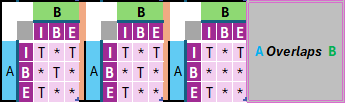

In [96]:
# Slice range = Min(starting slice) to Max(ending slice)
selected_slices = select_slices(slice_table, selected_roi)
# Send all slices with both Primary and Secondary contours for standard
# relation testing
mid_relations = selected_slices.agg(relate_structures,
                                    structures=selected_roi,
                                    axis='columns')
mid_relations.name = 'DE27IM'
#mid_relations

#### Confines Cylinders
- Identify the boundary slices of the Primary and the neighbouring slice(s) that do not have a primary.
- For each of these neighbouring slices, if the slice does not have a Secondary contour, but there is a Secondary contour on the same slice as the Primary boundary, select that Secondary slice.

  
![Confines cylinder](FreeCAD_Scripts/confines_cylinder.png)



5. Match hole boundary slices for boundary tests:
   - For each hole boundary slice of the Primary ROI, if the slice has a Secondary contour, select that contour for comparison.
   - If the slice does not have a Secondary contour, identify the neighbouring slice that also has a hole.
   - If the neighbouring slice has a Secondary contour, select that contour.
   - If the neighbouring slice does not have a Secondary contour, boundary testing is not required.


  

In [1]:
def confines_cylinder():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1.1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Centred cylinder with two embedded cylinders
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    left_hole = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=-2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    right_hole = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    # cylinder with interior borders
    confines_cylinder = make_vertical_cylinder(roi_num=2, radius=1, length=0.5,
                                             offset_x=2.5, offset_z=-0.2,
                                             spacing=slice_spacing)

    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, left_hole, right_hole,
                            confines_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#### Concentric cylinders ending on the same slice.

<img src="Images\Boundaries\PartitionInf3D.png" alt="PartitionInf3D" style="height:50px;">
<img src="Images\Boundaries\PartitionInf2D.png" alt="PartitionInf2D" style="height:30px;">

In [26]:
def concentric_cylinders_same_end():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Concentric cylinders ending on the same slice
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=2, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    inf_partition = make_vertical_cylinder(roi_num=3, radius=1, length=0.4,
                                           offset_z=0, spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, inf_partition])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#print(find_relationship(concentric_cylinders_same_end(), [1, 3]))


- Concentric cylinders starting and ending on the same slice.

<img src="Images\Boundaries\Partition3D.png" alt="PartitionInf3D" style="height:50px;">
<img src="Images\Boundaries\Partition2D.png" alt="PartitionInf2D" style="height:30px;">

In [27]:
def concentric_cylinders_same_height():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Concentric cylinders starting and ending on the same slice
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=2, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    mid_partition = make_vertical_cylinder(roi_num=4, radius=1, length=0.7,
                                           offset_z=-0.3,
                                           spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, mid_partition])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#print(find_relationship(concentric_cylinders_same_height(), [1, 4]))


### Exterior Borders
  - Primary: Central Cylinder
    - Secondary: one of:
      - SUP Cylinder
      - INF Cylinder
      - Combined SUP & INF cylinders in one structure with single slice gap at the SUP/INF boundary of the central cylinder.

      
![Exterior Border SUP](Images/Boundaries/ExteriorBorders2D_SUP.png)
![Exterior Border INF](Images/Boundaries/ExteriorBorders2D_INF.png)

In [28]:
def stacked_cylinders():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Two concentric cylinders different z offsets
    outside_cylinder = make_vertical_cylinder(roi_num=5, radius=2, length=0.4,
                                              offset_z=-0.4,
                                              spacing=slice_spacing)
    inside_cylinder = make_vertical_cylinder(roi_num=6, radius=1, length=0.4,
                                             offset_z=0, spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, outside_cylinder, inside_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#print(find_relationship(stacked_cylinders(), [5, 6]))


### Interior Borders
  - Primary: Central Cylinder
  - Concentric shorter hole in the center of the primary cylinder
  - Secondary same height as hole but narrower
  - Interior borders at the and bottom of hole.
  
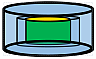
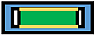

In [29]:
def embedded_cylinder():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    primary_cylinder = make_vertical_cylinder(roi_num=9, radius=4, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    center_hole = make_vertical_cylinder(roi_num=9, radius=2, length=0.5,
                                         offset_z=-0.2, spacing=slice_spacing)
    # Two concentric cylinders different z offsets
    middle_cylinder = make_vertical_cylinder(roi_num=10, radius=1, length=0.5,
                                             offset_z=-0.2,
                                             spacing=slice_spacing)
    reference = make_vertical_cylinder(roi_num=11, radius=2, length=0.5,
                                         offset_z=-0.2, spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, center_hole, middle_cylinder, reference])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#print(find_relationship(embedded_cylinder(), [9, 10]))


- The `boundary_match` and `match_neighbour_slices` functions will need to be updated to include the hole boundary tests.
  - For hole boundaries, select the neighboring slice (s) that *DO* have a hole contour.
  - The Secondary slice selection works as usual.

In [30]:
def dual_embedded_cylinder():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    left_hole = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=-2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    right_hole = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    # Two concentric cylinders different z offsets
    middle_cylinder = make_vertical_cylinder(roi_num=2, radius=1, length=0.5,
                                             offset_x=2.5, offset_z=-0.2,
                                             spacing=slice_spacing)

    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, left_hole, right_hole, middle_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#print(find_relationship(dual_embedded_cylinder(), [1, 2]))


In [ ]:
def overlapping_cylinders():
    slice_spacing = 0.5
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Two overlapping cylinders
    top_cylinder = make_vertical_cylinder(roi_num=7, radius=2, length=0.4, offset_z=-0.3, spacing=slice_spacing)
    bottom_cylinder = make_vertical_cylinder(roi_num=8, radius=2, length=0.4, offset_z=0, spacing=slice_spacing)
   # combine the contours
    slice_data = pd.concat([top_cylinder, bottom_cylinder, body])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#print(find_relationship(overlapping_cylinders(), [7, 8]))


# More Tests Needed

  - Single Primary slice with circular contour.
    - Secondary: one of:
      - SUP Cylinder
      - INF Cylinder
      - Combined SUP & INF Cylinders in one structure with single slice gap at level of the primary slice. 
- **Partition**
  - Concentric cylinders ending on the same slice.
  - Concentric cylinders starting on the same slice
  - Primary: Central Cylinder
    - Single Secondary slice with circular contour on the SUP/INF slice of the Primary cylinder.
  - Single Primary slice with circular contour
    - Secondary: one of:
      - SUP Cylinder ending on the same slice.
      - INF Cylinder ending on the same slice.
- **CONTAINS**
  - Concentric cylinders with interior cylinder ending inside the exterior cylinder by one slice
**OVERLAPS**
  - Concentric cylinders with interior cylinder ending outside the exterior cylinder by one slice
  - Concentric cylinders with interior cylinder consisting of single slice ending inside the exterior cylinder by one slice


  - Primary: Central Cylinder
    - Secondary: one of:
      - SUP Cylinder
      - INF Cylinder
      - Combined SUP & INF cylinders in one structure with single slice gap at the SUP/INF boundary of the central cylinder.
  - Single Primary slice with circular contour.
    - Secondary: one of:
      - SUP Cylinder
      - INF Cylinder
      - Combined SUP & INF Cylinders in one structure with single slice gap at level of the primary slice. 
